<a href="https://colab.research.google.com/github/jx-dohwan/Aiffel_EGLMS_Project/blob/main/%5BExp_12%5DSummarize_news_articles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Exp_12]Summarize news articles
> ### 이번 프로젝트를 통해서는 뉴스 요약봇 만들기이다. 
긴 길이의 원문을 핵심 주제만으로 구성된 짧은 요약 문장들로 변환하는 텍스트 요약을 하게 될 것이다.<br>
텍스트 요약에는 추상적 요약과 추출적 요약으로 크게 두가지로 나눌 수 있다. 
- 추출적 요약(Extractive Summarization)
  - 추출적 요약은 단어 그대로 원문에서 문장들을 추출해서 요약하는 방식이에요. 가령, 10개의 문장으로 구성된 텍스트가 있다면, 그중 핵심적인 문장 3개를 꺼내와서 3개의 문장으로 구성된 요약문을 만드는 식이다.
  - 딥 러닝보다는 주로 전통적인 머신 러닝 방식에 속하는 텍스트 랭크(TextRank)와 같은 알고리즘을 사용해서 이 방법을 사용한다
- 추상적 요약(Abstractive Summarization)
  -  원문으로부터 내용이 요약된 새로운 문장을 생성해낸다. 여기서 새로운 문장이라는 것은 결과로 나온 문장이 원문에 원래 없던 문장일 수도 있다는 것을 의미합니다
  - 자연어 처리 분야 중 자연어 생성(Natural Language Generation, NLG)의 영역인 셈이다. 

> ### 사용하는 모델개요
seq2seq 모델을 통해서 Abstractive summarization 방식의 텍스트 요약기를 만들 것이다.<br>seq2seq은 두 개의 RNN 아키텍처를 사용하여 입력 시퀀스로부터 출력 시퀀스를 생성해 내는 자연어 생성 모델이다.
- 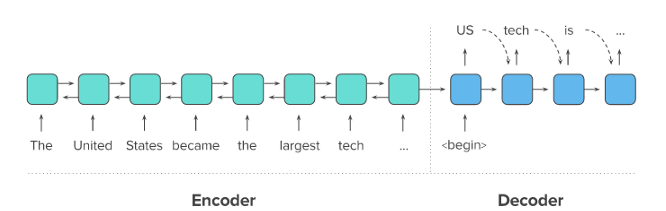
> 원문을 첫 번째 RNN인 인코더로 입력하면, 인코더는 이를 하나의 고정된 벡터로 변환해요. 이 벡터를 문맥 정보를 가지고 있는 벡터라고 하여 컨텍스트 벡터(context vector)라고 합니다. 두 번째 RNN인 디코더는 이 컨텍스트 벡터를 전달받아 한 단어씩 생성해내서 요약 문장을 완성하는 것이다.


> ### 실제 사용 모델
seq2seq를 구현할 때 LSTM 모델을 사용할 것이다. LSTM이 바닐라 RNN과 다른 점은 인코더가 디코더에 전달하는 컨텍스트 벡터 또한 hidden state h와 cell state c 두 개의 값 모두 존재해야 한다는 뜻이다.
- 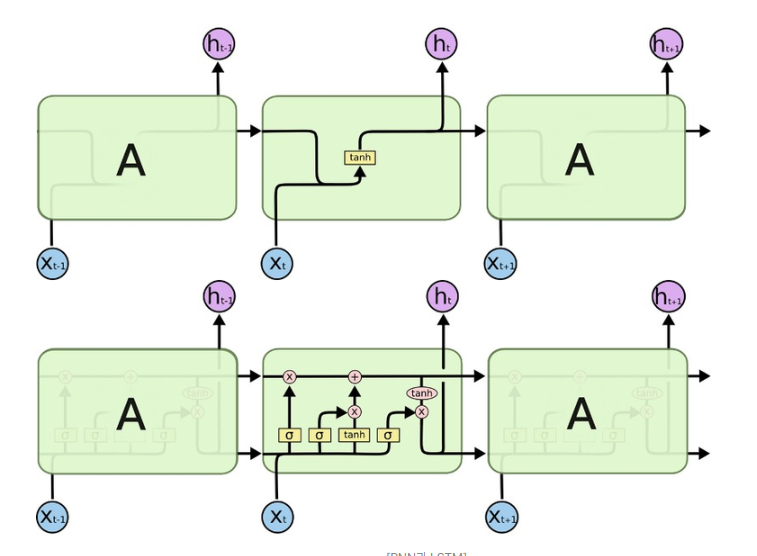
> 축적으로 기본 seq2seq가 아닌 어텐션 매커니즘을 사용할 것이다. 
어텐션 매커니즘은 인코더의 모든 step의 hidden state의 정보가 컨텍스트 벡터에 전부 반영되도록 하는 것이다. <br>여기서 주의해야 할 것은, 컨텍스트 벡터를 구성하기 위한 인코더 hidden state의 가중치 값은 디코더의 현재 스텝이 어디냐에 따라 계속 달라진다는 점이다.<br> 쉽게말해어텐션 메커니즘을 이용해 인코더의 hidden state의 중요도를 취합한 컨텍스트 벡터를 디코더 스텝별로 계산한다.
- 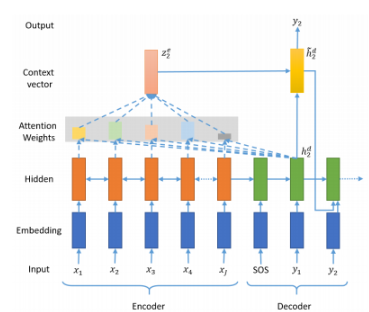

## 1.import

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2.데이터 수집하기
- https://github.com/sunnysai12345/News_Summary -> 여기에 있는 news_summary_more.csv를 사용
- 추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요.
- 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.

In [2]:
data = pd.read_csv('/content/drive/MyDrive/인공지능/아이펠/ES/data/News_Summary-master/news_summary_more.csv')
print('전체 샘플 수 : ', (len(data)))

전체 샘플 수 :  98401


In [3]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


## 3. 데이터 전처리하기(추상적 요약)
- 실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요
-  만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

### 1) 중복 샘플과 NULL값이 존재하는 샘플제거

In [4]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [5]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [6]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


### 2) 텍스트 정규화와 불용어 제거

In [7]:
contractions = {"isn't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  119


- ais't -> isn't로 고쳤다.

In [8]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [9]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens


In [10]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [11]:
clean_summary = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_summary[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [12]:
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)


In [13]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

### 3) 훈련데이터와 테스트데이터 나누기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


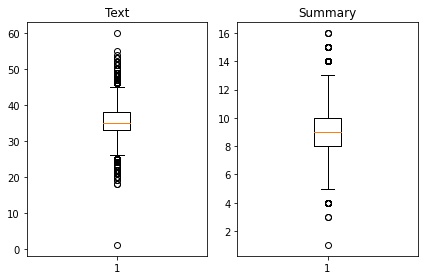

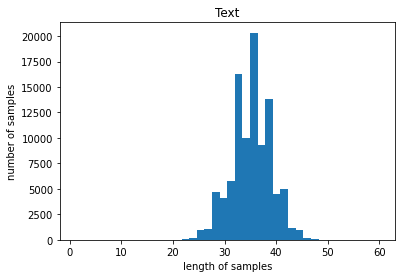

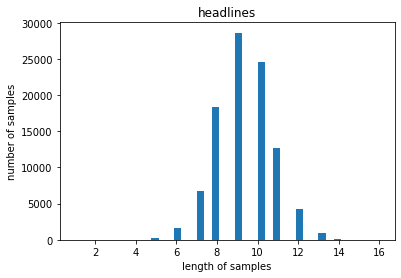

In [14]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [15]:
text_max_len = 45
headlines_max_len = 12

- 그래프에서 눈에 제일 큰 값들은 아니지만 눈에 보일 정도로 많은 값을 보이고 있는 42와 12를 max_len으로 잡았다.

In [16]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))


In [17]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967771451809678
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


In [18]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [19]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블


In [20]:

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[10955 58832 49334 ... 24102 82276 80533]


In [21]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]


In [22]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19672


In [23]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


### 4) 정수 인코딩

In [24]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성


In [25]:
threshold = 6
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69593
등장 빈도가 5번 이하인 희귀 단어의 수: 45607
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 23986
단어 집합에서 희귀 단어의 비율: 65.5338899027201
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.0860377235501493


In [26]:
src_vocab = 24000
src_tokenizer = Tokenizer(num_words=src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성


In [27]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[27, 20, 61, 3687, 78, 1116, 847, 3160, 76, 188, 6248, 12945, 946, 448, 426, 28, 78, 10264, 8829, 12945, 1580, 847, 10694, 1363, 4057, 8829, 848, 170, 143, 6, 13336, 4760, 100, 20, 1, 1465, 8830, 12945], [38, 89, 11568, 3760, 8984, 1211, 19, 6904, 10695, 785, 1216, 735, 2616, 2314, 2272, 1977, 1102, 57, 586, 47, 109, 8985, 62, 8984, 1041, 78, 2236, 2940, 5091, 363, 260, 3474, 1923, 4679, 904, 347, 76, 1188, 10469, 404, 89], [51, 1782, 2105, 345, 358, 3302, 3214, 1102, 4201, 196, 15, 1271, 12, 192, 2841, 715, 323, 175, 283, 1782, 1, 276, 674, 4, 1594, 968, 2067, 196, 337]]


In [28]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [29]:
threshold = 5
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30035
등장 빈도가 4번 이하인 희귀 단어의 수: 18486
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11549
단어 집합에서 희귀 단어의 비율: 61.548193773930414
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.935810248205472


In [30]:
tar_vocab = 11000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 28, 37, 3336, 4, 1799, 65, 985, 16, 5416, 1629], [1, 32, 117, 42, 2811, 339, 821, 14, 216, 126], [1, 191, 533, 17, 580, 60, 3250, 520], [1, 22, 36, 328, 8806, 94, 122, 78, 1732, 75, 7, 130, 560], [1, 701, 676, 3, 2812, 759, 7, 4535, 3337, 4687, 8205]]
target
decoder  [[28, 37, 3336, 4, 1799, 65, 985, 16, 5416, 1629, 2], [32, 117, 42, 2811, 339, 821, 14, 216, 126, 2], [191, 533, 17, 580, 60, 3250, 520, 2], [22, 36, 328, 8806, 94, 122, 78, 1732, 75, 7, 130, 560, 2], [701, 676, 3, 2812, 759, 7, 4535, 3337, 4687, 8205, 2]]


In [31]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


In [32]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')


## 4.어텐션 메커니즘 사용하기(추상적 요약)
- 일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요

### 1) 모델 설계

- hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터로  LSTM의 용량의 크기나, LSTM에서의 뉴런의 개수라고 이해하면 된다.(무조건 크다고 좋은건 아니다.)
- 인코더의 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높였다.
  -  hidden state의 크기를 늘리는 것이 LSTM 층 1개의 용량을 늘린다면, 3개의 층을 사용하는 것은 모델의 용량을 늘린다고 볼 수있다.
  - LSTM은 dropout 뿐 아니라 recurrent dropout까지 사용할 수 있다.
    - dropout은 레이어의 weight를 랜덤으로 생략하여 모델의 과적합(overfitting)을 해결해주는 방법
    - recurrent dropout은 dropout을 레이어가 아닌 time step마다 해주는 방식으로 time step의 입력을 랜덤으로 생략해 주는 것이다. 이는 regularization을 해주는 효과가 있고 과적합을 방지할 수 있다.
    - dropout vs recurrent dropout(이미지)
      - 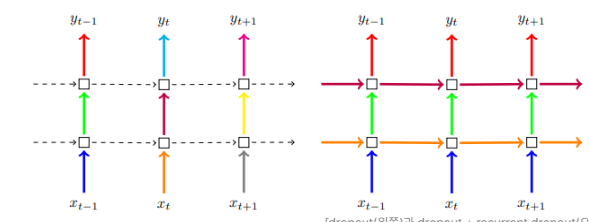

#### (1) 인코더

In [33]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

- 디코더의 출력층에서는 Summary의 단어장인 tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야 해요. 그렇기 때문에 Dense의 인자로 tar_vocab을 주고, 활성화 함수로 소프트맥스 함수를 사용하고 있다.

#### (2) 디코더

In [34]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [35]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 45)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 45, 128)      3072000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 45, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

#### (3) 어텐션 메커니즘
- 어텐션 메커니즘을 수행하는 어텐션 함수를 설계하는 것은 또 다른 새로운 신경망을 설계해야 한다는 뜻
- 여기서 사용하는 어텐션 함수는 Bahdanau 스타일의 어텐션
-  인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고, 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동


In [36]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 45)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 45, 128)      3072000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 45, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

### 2) 모델 훈련

In [37]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 39s 104ms/step - loss: 5.7007 - val_loss: 5.2467
Epoch 2/50
308/308 [==============================] - 32s 103ms/step - loss: 5.0985 - val_loss: 4.9088
Epoch 3/50
308/308 [==============================] - 33s 107ms/step - loss: 4.7688 - val_loss: 4.6415
Epoch 4/50
308/308 [==============================] - 33s 106ms/step - loss: 4.5133 - val_loss: 4.4612
Epoch 5/50
308/308 [==============================] - 32s 105ms/step - loss: 4.3062 - val_loss: 4.3132
Epoch 6/50
308/308 [==============================] - 33s 106ms/step - loss: 4.1335 - val_loss: 4.1966
Epoch 7/50
308/308 [==============================] - 33s 106ms/step - loss: 3.9812 - val_loss: 4.1116
Epoch 8/50
308/308 [==============================] - 33s 106ms/step - loss: 3.8499 - val_loss: 4.0328
Epoch 9/50
308/308 [==============================] - 33s 106ms/step - loss: 3.7353 - val_loss: 3.9782
Epoch 10/50
308/308 [==============================] - 33s 106ms/step - l

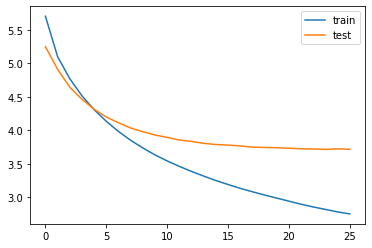

In [38]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 3) 인퍼런스 모델 구현
- 훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비했다.
- 그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 합니다. 이때는 인코더 모델과 디코더 모델을 분리해서 설계한다.



In [39]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [40]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])



In [41]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])



In [42]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence


### 3) 모델 테스트

In [43]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp



## 5.실제 결과와 요약문 비교하기(추상적 요약)
- 원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

In [44]:
for i in range(60, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : european food delivery startup backed rocket internet delivery hero announced plans raise million public listing frankfurt stock exchange said biggest ipo germany comes naspers invested million delivery hero last month six year old delivery hero says services cover countries worldwide 
실제 요약 : delivery hero announces plan for germany biggest ipo 
예측 요약 :  german startup raises mn in us startup


원문 : andhra pradesh minister narayana son friend raja ravi wednesday died road accident driving benz car around car hit metro pillar police said however yet clear drunk post mortem results would later 
실제 요약 : andhra minister son killed in road accident in hyderabad 
예측 요약 :  son of son killed in accident accident in maharashtra


원문 : afghanistan registered last win ireland world cup qualifier friday book place team cricket world cup edition afghanistan second successive world cup meanwhile zimbabwe featured last nine editions missed world cup place first time since 
실제 요약 : afghanistan i

## 6. Summa을 이용해서 추출적 요약해보기
- 추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요
- 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.
- Summa의 summarize를 사용하여 추출적 요약을 해보세요.

In [45]:
! pip list | grep summa

summa                         1.2.0
torchsummary                  1.5.1


In [46]:
! pip install summa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
import requests
from summa.summarizer import summarize

In [48]:
data2 = pd.read_csv('/content/drive/MyDrive/인공지능/아이펠/ES/data/News_Summary-master/news_summary_more.csv')
print('전체 샘플 수 : ', (len(data2)))

전체 샘플 수 :  98401


> LMS상에는 그냥 추출적 요약을 했지만 여기에서는 전처리를 하고 추출적 요약값을 보려고 한다. 물론 전처리 전에도 추출적 요약을 해보았다.
- 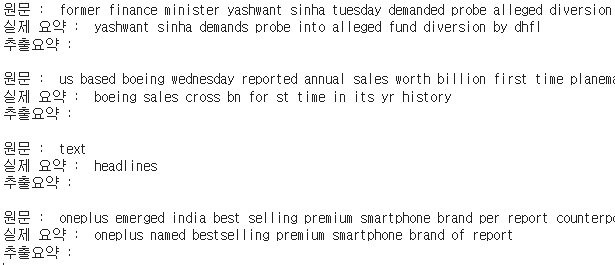

> 전처리로 인해 데이터 소실로 아무런 결과가 나오지 않는 것을 확인할 수 있었다.

In [49]:
# clean_text2 = []
# # 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
# for s in data2['text']:
#     clean_text2.append(preprocess_sentence(s))

# # 전처리 후 출력
# print("Text 전처리 후 결과: ", clean_text2[:5])

In [50]:
# clean_summary2 = []
# # 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
# for s in data2['headlines']:
#     clean_summary2.append(preprocess_sentence(s, False))

# print("headlines 전처리 후 결과: ", clean_summary2[:5])

In [51]:
# data2['text'] = clean_text2
# data2['headlines'] = clean_summary2

# # 빈 값을 Null 값으로 변환
# data.replace('', np.nan, inplace=True)


In [57]:
for i in range(60, 100):
  print('원문 : ',data2['text'][i])
  print('실제 요약 : ',data2['headlines'][i])
  print('추출요약 : ', summarize(data2['text'][i], ratio=0.5))
  print()

원문 :  The Finance Ministry on Wednesday said the government will present an Interim Budget on February 1. The clarification came amid speculations that a full Budget may be presented during the session. The government recently assigned Piyush Goyal temporary additional charge of the Finance and Corporate Affairs ministries in the absence of Arun Jaitley, who is in the US for treatment.
실제 요약 :  Govt to present Interim Budget, not full Budget on February 1
추출요약 :  The Finance Ministry on Wednesday said the government will present an Interim Budget on February 1.

원문 :  US President Donald Trump on Wednesday called his country's top intelligence chiefs "naive" and "wrong" on Iran and added that they should perhaps "go back to school". Trump claimed Iran is testing rockets, calling the country "a source of potential danger and conflict". Top US intelligence officials on Tuesday said that Iran isn't currently taking steps towards building nuclear weapons.
실제 요약 :  US intelligence naive and

- ratio를 너무 작게 하니까 추출요약이 아예 안나와서 값을 올렸다.
  - 0.4까지 안나오는 문장이 발견되어 0.5로 지정을 하였다. 문장이 완전히 소실되지 않은 상태에서 최대로 요약할 수 있는 값이다.

## 8. 추상적 요약과 추출적 요약 비교
- 추출적 요약
  - 우선 추출적 요약은 실제 원문의 문자를 그대로 가져오고 있으며 실제 요약보다는 조금 길게 가져와 요약이 덜 된 감이 없지 않아 있지만 그래도 핵심 단어는 많이 추출하고 있다.
- 추상적 요약
  - 추상적 요약은 문법을 완성하고 텍스트 내용과 관련된 추제를 뽑아낸다. 하지만 실제 주제와는 맞는 않는 경향도 종종 발견되고 있다.
  - 정확도를 더 올릴 필요가 있다. 단어장 크기 조정? max_len 조정? 모델 구현단 조정? 등을 조정하여 정확도를 더 올릴 필요가 있다.
  - 확실히 단어장 크기를 늘리니 표현이 좀 더 풍부해지고 문법이 정확해진 것 같다. 하지만 여기서 크기를 더 늘리면 오히려 정확도가 더 안좋아질 수 있을 것 같다.

## 7.회고
- 루브릭 기준을 맞추기 위해서 시도한 것
  - LMS와는 단어의 크기가 다르다. 그래서 text의 max_len의 경우는 그래프상 눈에 띄게 분포가 있는 부분까지 포함해서 45로 지정하였고 headlines의 경우에도 그래프상 눈에 띄게 분포해 있는 부분까지 해서 12로 지정하엿다.
  - 그리고 LMS보다 단어집합의 크기를 늘리면 보다 풍성하게 표현하지 않을까 싶어서 반복되는 단어의 횟수를 줄여 희귀단어를 제외한 문장 크기를 확인후 늘어난 단어장 크기를 적용하였다.
  - 추출적 문장과 추상적 문장을 비교해보았다.
  - 로스가 하향하는 것을 확인할 수 있다. 상향할때쯤 자동으로 멈추게 설계가 되어 있다. 
- 공부한 것 
  - RNN의 개념가 LSTM의 개념을 다시 한 번 되새겼고 어텐션 매커니즘을 새로 배웠다.
    - 어텐션 매커니즘은 LSTM의 단점을 보완하여 모든 정보를 각 스텝별로 중요도에 따라서 적용하는 알고리즘이다.
- 공부해볼 것
  - recurrent dropout : https://arxiv.org/pdf/1603.05118v2.pdf
  - 텐서플로우 어텐션 설계 : https://www.tensorflow.org/api_docs/python/tf/keras/layers/AdditiveAttention
  - 강화학습을 사용한 텍스트 요약 개념 : https://medium.com/dl-for-product-and-service/abstractive-text-summary-with-reinforcement-learning-ab2458ab29d5
  - RNN, LSTM : http://colah.github.io/posts/2015-08-Understanding-LSTMs/
  - 구글활용기사 : https://zdnet.co.kr/view/?no=20160905114833&from=Mobile


- 아쉬웠던 점
  - 추출적 요약은 실제 문장에서 그대로 가져오니 정확도가 많이 떨어지지는 않는다. 그러나 추상적 요약의 경우에는 정확도가 많이 떨어지는 것을 확인할 수 있다. 
  - 이것을 어떻게 개선할지 조금 더 딥한 공부가 필요해 보인다. 내가 알기로는 고잉디퍼때 이부분을 조금 더 깊게 다루는 것으로 알고 있다. 지금의 낮은 정확도에 대한 한을 가지고 고잉디퍼때 보다 적극적으로 임할 수 있을 것 같다.
